In [1]:
#!pip install qlearnkit['pennylane']
#!pip install --upgrade scipy pennylane
#!pip install pennylane
#!pip install --upgrade numpy pennylane
#!pip install pennylane-lightning
#!pip install --upgrade torch



In [2]:
import torch
import torch.nn as nn
import pennylane as qml
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:


class QLSTM(nn.Module):

    def custom_encoding(self, inputs, wires):
        # Apply Hadamard to each qubit to create an unbiased initial state
        for wire in range(self.n_qubits):
            qml.Hadamard(wires=wire)

        qml.templates.AngleEmbedding(torch.sin(inputs), rotation='Y', wires=wires)
        qml.templates.AngleEmbedding(torch.cos(inputs ** 2), rotation='Z', wires=wires)


    def custom_entangler_layer(self, weights, wires):
        for l in range(self.n_qlayers):  # Repeat the sequence twice
            # Apply CNOTs for the specified entanglement structure
            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[1, 2])
            qml.CNOT(wires=[2, 3])
            qml.CNOT(wires=[3, 0])
            qml.CNOT(wires=[0, 2])
            qml.CNOT(wires=[1, 3])
            qml.CNOT(wires=[2, 0])
            qml.CNOT(wires=[3, 1])
            #print("Weights shape:", weights.shape)


            # Apply general rotation for each qubit
            for i, wire in enumerate(wires):
                qml.Rot(*weights[l, i, :], wires=wire)



    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=2,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        self.wires_forget = list(range(self.n_qubits))
        self.wires_input = list(range(self.n_qubits))
        self.wires_update = list(range(self.n_qubits))
        self.wires_output = list(range(self.n_qubits))
        self.wires_hidden = list(range(self.n_qubits))
        self.wires_output_pre = list(range(self.n_qubits))

        self.dev_forget = qml.device('default.qubit', wires=self.wires_forget)
        self.dev_input = qml.device('default.qubit', wires=self.wires_input)
        self.dev_update = qml.device('default.qubit', wires=self.wires_update)
        self.dev_output = qml.device('default.qubit', wires=self.wires_output)
        self.dev_hidden = qml.device('default.qubit', wires=self.wires_hidden)
        self.dev_output_pre = qml.device('default.qubit', wires=self.wires_output_pre)



        def _circuit_forget(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_forget)
            self.custom_entangler_layer(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_input)
            self.custom_entangler_layer(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_update)
            self.custom_entangler_layer(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_output)
            self.custom_entangler_layer(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        def _circuit_hidden(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_hidden)
            self.custom_entangler_layer(weights, wires=self.wires_hidden)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_hidden]
        self.qlayer_hidden = qml.QNode(_circuit_hidden, self.dev_hidden, interface="torch")

        def _circuit_output_pre(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_output_pre)
            self.custom_entangler_layer(weights, wires=self.wires_output_pre)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output_pre]
        self.qlayer_output_pre = qml.QNode(_circuit_output_pre, self.dev_output_pre, interface="torch")

        weight_shapes = {"weights": (self.n_qlayers, self.n_qubits, 3)}
        print(f"weight_shapes = (n_qlayers, n_qubits, 3) = ({n_qlayers}, {n_qubits}, 3)")

        self.clayer_in = torch.nn.Linear(self.hidden_size + self.n_inputs, self.n_qubits)
        print("Initialized clayer_in weight shape:", self.clayer_in.weight.shape)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes),
            'hidden': qml.qnn.TorchLayer(self.qlayer_hidden, weight_shapes),
            'output_pre': qml.qnn.TorchLayer(self.qlayer_output_pre, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)


    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:

            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]

            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)
            #print("Shape of concatenated input v_t:", v_t.shape)
            #print("Weight shape of clayer_in:", self.clayer_in.weight.shape)
            # match qubit dimension
            #self.clayer_in = torch.nn.Linear(6, 4)
            v_t = self.clayer_in(v_t)
            #print("Shape after clayer_in:", v_t.shape)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](v_t)))
            #print("Shape of forget block output:", f_t.shape)  # forget block

            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](v_t)))
            #print("Shape of input block output:", i_t.shape)   # input block

            g_t = torch.tanh(self.clayer_out(self.VQC['update'](v_t)))
            c_t = (f_t * c_t) + (i_t * g_t)

            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](v_t)))
            #print("Shape of output block output:", o_t.shape) # output block

            h_t = self.VQC['hidden'](o_t * torch.tanh(c_t))
            y_tilde = self.VQC['output_pre'](o_t * torch.tanh(c_t))
            y_t = self.clayer_out(y_tilde)

            hidden_seq.append(h_t.unsqueeze(0))

        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        return hidden_seq, (h_t, c_t)

LSTM hidden layer size: 4
Number of qubits: 4
Training epochs: 200
Learning rate: 0.01
RMSprop alpha: 0.99
RMSprop eps: 1e-08
Sample size: 1000
Sequence length: 4
Input size: 7


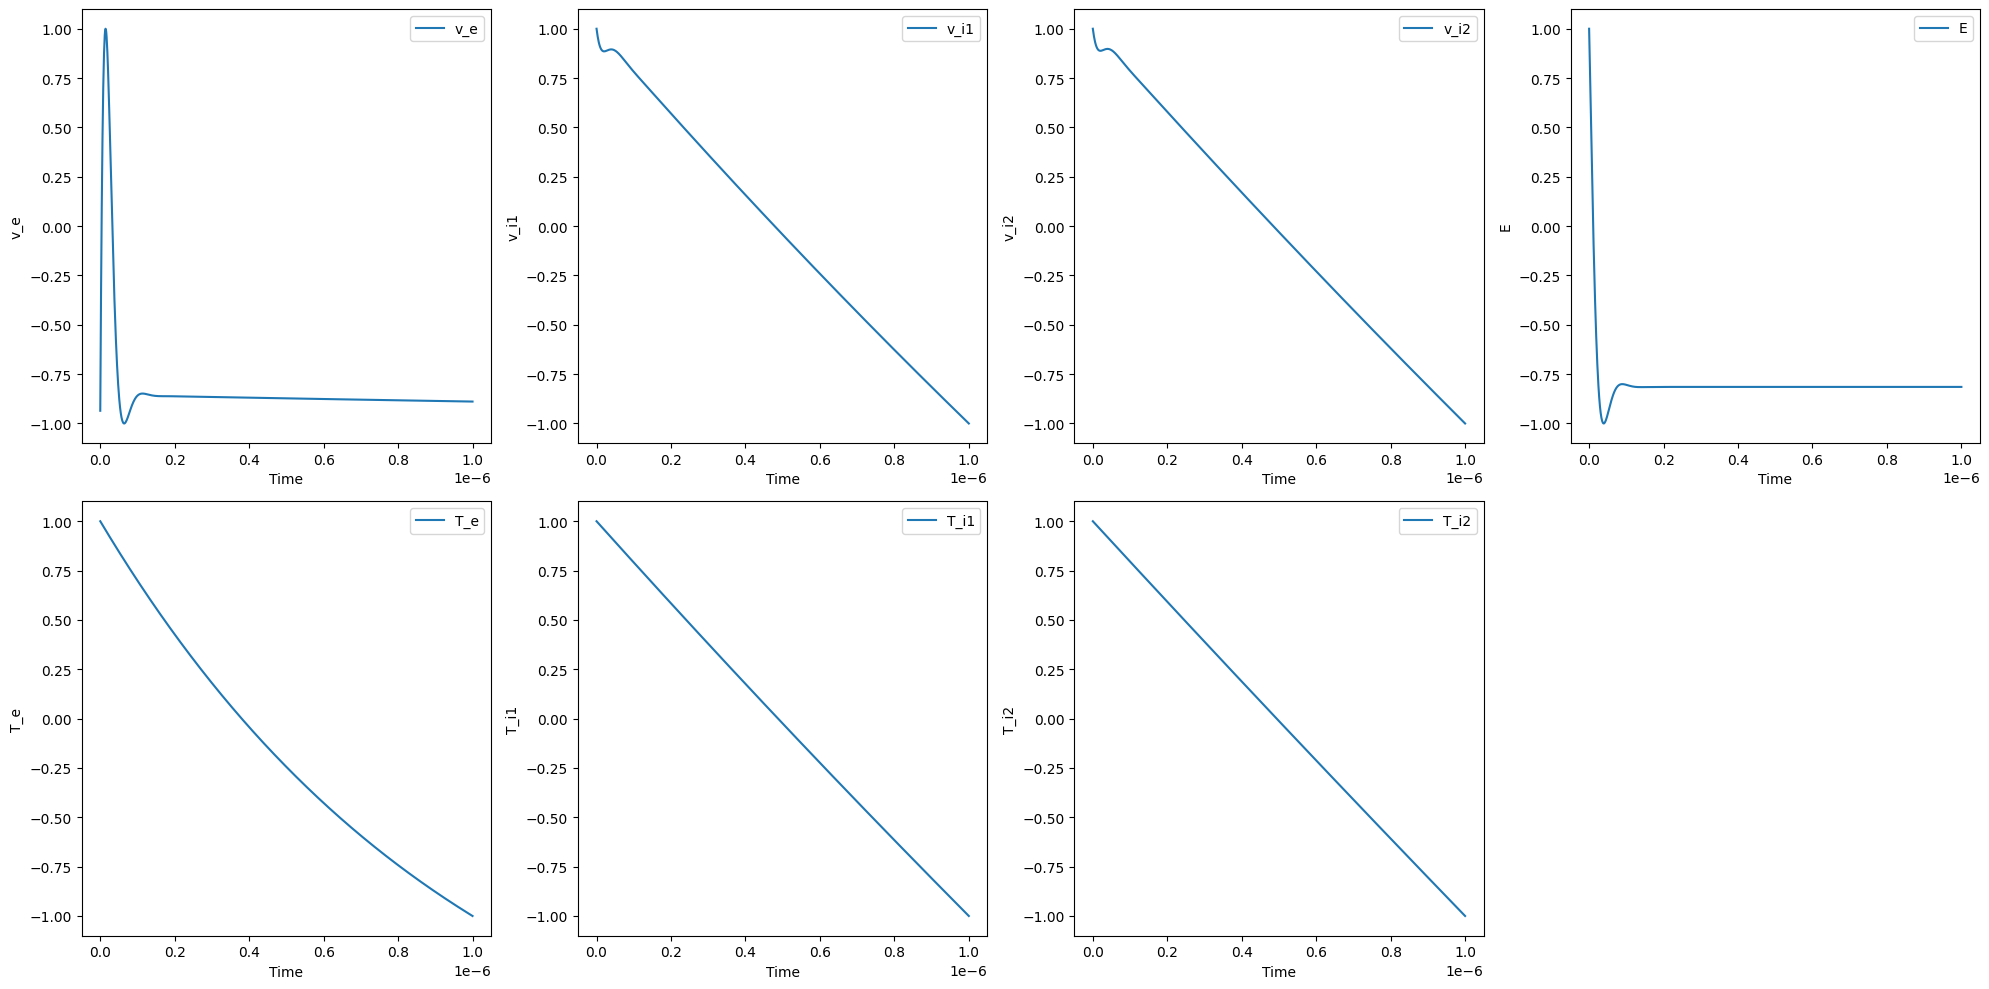

Tagger will use Quantum LSTM running on backend default.qubit
weight_shapes = (n_qlayers, n_qubits, 3) = (2, 4, 3)
Initialized clayer_in weight shape: torch.Size([4, 11])
Epoch 1, Train Loss: 0.3117, Test Loss: 0.3632
Epoch 2, Train Loss: 0.2219, Test Loss: 0.3772
Epoch 3, Train Loss: 0.2023, Test Loss: 0.3819
Epoch 4, Train Loss: 0.1941, Test Loss: 0.3809
Epoch 5, Train Loss: 0.1842, Test Loss: 0.3737
Epoch 6, Train Loss: 0.1775, Test Loss: 0.3672
Epoch 7, Train Loss: 0.1690, Test Loss: 0.3580
Epoch 8, Train Loss: 0.1616, Test Loss: 0.3467
Epoch 9, Train Loss: 0.1536, Test Loss: 0.3338
Epoch 10, Train Loss: 0.1458, Test Loss: 0.3198
Epoch 11, Train Loss: 0.1377, Test Loss: 0.3057
Epoch 12, Train Loss: 0.1294, Test Loss: 0.2911
Epoch 13, Train Loss: 0.1210, Test Loss: 0.2771
Epoch 14, Train Loss: 0.1126, Test Loss: 0.2631
Epoch 15, Train Loss: 0.1043, Test Loss: 0.2499
Epoch 16, Train Loss: 0.0960, Test Loss: 0.2371
Epoch 17, Train Loss: 0.0882, Test Loss: 0.2252
Epoch 18, Train Loss: 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, Subset
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the LSTM model
class LSTMTagger(nn.Module):
    def __init__(self, input_size, hidden_dim, sequence_length, n_qubits=0, output_size=7, num_layers=2, backend='default.qubit'):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        if n_qubits > 0:
            print(f"Tagger will use Quantum LSTM running on backend {backend}")
            self.lstm = QLSTM(input_size, hidden_dim, n_qubits=n_qubits)
        else:
            print("Tagger will use Classical LSTM")
            self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_timestep_output = lstm_out[:, -1, :]
        fc_out = self.fc(last_timestep_output)
        return fc_out

batch_size = 128

# Hyperparameters and configurations
class Args:
    hidden_dim = 4
    n_qubits = 4
    n_epochs = 200
    backend = 'default.qubit'
    learning_rate = 0.01
    sequence_length = 4
    sample_size = 1000
    alpha = 0.99
    eps = 1e-8
    input_size = 7

args = Args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"LSTM hidden layer size: {args.hidden_dim}")
print(f"Number of qubits: {args.n_qubits}")
print(f"Training epochs: {args.n_epochs}")
print(f"Learning rate: {args.learning_rate}")
print(f"RMSprop alpha: {args.alpha}")
print(f"RMSprop eps: {args.eps}")
print(f"Sample size: {args.sample_size}")
print(f"Sequence length: {args.sequence_length}")
print(f"Input size: {args.input_size}")

def normalize(data):
    data_min, data_max = np.min(data), np.max(data)
    if data_max - data_min == 0:
        return data
    return 2 * (data - data_min) / (data_max - data_min) - 1

# Plasma dynamics system parameters
e = 1.602e-19  # Electron charge (C)
m_e = 9.109e-31  # Electron mass (kg)
m_i1 = 1.673e-27  # Ion species 1 mass (kg, hydrogen ion)
m_i2 = 3.345e-27  # Ion species 2 mass (kg, helium ion)
epsilon_0 = 8.854e-12  # Permittivity of free space (F/m)
nu_e = 1e8  # Electron collision frequency (s^-1)
nu_i1 = 1e5  # Ion species 1 collision frequency (s^-1)
nu_i2 = 5e4  # Ion species 2 collision frequency (s^-1)
n_e = 1e18  # Electron density (m^-3)
n_i1 = 1e18  # Ion species 1 density (m^-3)
n_i2 = 5e17  # Ion species 2 density (m^-3)
gamma_e = 1e6  # Electron thermal relaxation rate
gamma_i1 = 1e5  # Ion species 1 thermal relaxation rate
gamma_i2 = 5e4  # Ion species 2 thermal relaxation rate

# ODE system for plasma dynamics
def plasma_dynamics(t, y):
    v_e, v_i1, v_i2, E, T_e, T_i1, T_i2 = y
    dv_e_dt = -e / m_e * E - nu_e * v_e
    dv_i1_dt = e / m_i1 * E - nu_i1 * v_i1
    dv_i2_dt = e / m_i2 * E - nu_i2 * v_i2
    dE_dt = -e / epsilon_0 * (n_i1 * v_i1 + n_i2 * v_i2 - n_e * v_e)
    dT_e_dt = -gamma_e * T_e
    dT_i1_dt = -gamma_i1 * T_i1
    dT_i2_dt = -gamma_i2 * T_i2
    return [dv_e_dt, dv_i1_dt, dv_i2_dt, dE_dt, dT_e_dt, dT_i1_dt, dT_i2_dt]

# Initial conditions
initial_state = [0.1, 0.1, 0.1, 1, 1, 1, 1]

# Time span and time steps for the simulation
t_span = (0, 1e-6)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solve the differential equation
sol = solve_ivp(plasma_dynamics, t_span, initial_state, method='Radau', t_eval=t_eval)

# Extracting the plasma dynamics system data
v_e, v_i1, v_i2, E, T_e, T_i1, T_i2 = sol.y

# Normalize the data
v_e_normalized = normalize(v_e)
v_i1_normalized = normalize(v_i1)
v_i2_normalized = normalize(v_i2)
E_normalized = normalize(E)
T_e_normalized = normalize(T_e)
T_i1_normalized = normalize(T_i1)
T_i2_normalized = normalize(T_i2)

# Plotting each dimension of the plasma dynamics system
plt.figure(figsize=(20, 10))

plt.subplot(2, 4, 1)
plt.plot(t_eval, v_e_normalized, label='v_e')
plt.xlabel('Time')
plt.ylabel('v_e')
plt.legend()

plt.subplot(2, 4, 2)
plt.plot(t_eval, v_i1_normalized, label='v_i1')
plt.xlabel('Time')
plt.ylabel('v_i1')
plt.legend()

plt.subplot(2, 4, 3)
plt.plot(t_eval, v_i2_normalized, label='v_i2')
plt.xlabel('Time')
plt.ylabel('v_i2')
plt.legend()

plt.subplot(2, 4, 4)
plt.plot(t_eval, E_normalized, label='E')
plt.xlabel('Time')
plt.ylabel('E')
plt.legend()

plt.subplot(2, 4, 5)
plt.plot(t_eval, T_e_normalized, label='T_e')
plt.xlabel('Time')
plt.ylabel('T_e')
plt.legend()

plt.subplot(2, 4, 6)
plt.plot(t_eval, T_i1_normalized, label='T_i1')
plt.xlabel('Time')
plt.ylabel('T_i1')
plt.legend()

plt.subplot(2, 4, 7)
plt.plot(t_eval, T_i2_normalized, label='T_i2')
plt.xlabel('Time')
plt.ylabel('T_i2')
plt.legend()

plt.tight_layout()
plt.show()

# Ensure no NaN or infinity values are present
def clean_data(data):
    return np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)


data_list = [v_e, v_i1, v_i2, E, T_e, T_i1, T_i2]
data_names = ['v_e', 'v_i1', 'v_i2', 'E', 'T_e', 'T_i1', 'T_i2']

for data, name in zip(data_list, data_names):
    if np.any(np.isnan(data)) or np.any(np.isinf(data)):
        print(f'{name} contains NaN or infinity values')

# Cleaning the data
v_e = clean_data(v_e)
v_i1 = clean_data(v_i1)
v_i2 = clean_data(v_i2)
E = clean_data(E)
T_e = clean_data(T_e)
T_i1 = clean_data(T_i1)
T_i2 = clean_data(T_i2)

# Reshape the data for LSTM input
num_samples = len(t_eval) - args.sequence_length + 1

# Initialize data array
data = np.zeros((num_samples, args.sequence_length, args.input_size))

# Populate the data array with sequences of plasma dynamics values
for i in range(num_samples):
    data[i, :, 0] = v_e_normalized[i:i + args.sequence_length]
    data[i, :, 1] = v_i1_normalized[i:i + args.sequence_length]
    data[i, :, 2] = v_i2_normalized[i:i + args.sequence_length]
    data[i, :, 3] = E_normalized[i:i + args.sequence_length]
    data[i, :, 4] = T_e_normalized[i:i + args.sequence_length]
    data[i, :, 5] = T_i1_normalized[i:i + args.sequence_length]
    data[i, :, 6] = T_i2_normalized[i:i + args.sequence_length]

# Convert to PyTorch tensors
data = torch.tensor(data, dtype=torch.float32)

# Create dataset
input_sequences = data[:-1]
labels = data[1:, -1, :]
dataset = TensorDataset(input_sequences, labels)

# Split the data into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Create subsets to maintain order
train_dataset = Subset(dataset, list(range(train_size)))
test_dataset = Subset(dataset, list(range(train_size, len(dataset))))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = LSTMTagger(input_size=args.input_size, hidden_dim=args.hidden_dim,
                   sequence_length=args.sequence_length, n_qubits=args.n_qubits,
                   output_size=args.input_size, backend=args.backend).float().to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=args.learning_rate, alpha=args.alpha, eps=args.eps)

# Training loop with gradient clipping
train_losses = []
test_losses = []

for epoch in range(1, args.n_epochs + 1):
    model.train()
    epoch_train_losses = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_function(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_train_losses.append(loss.item())

    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)

    # Evaluation on test data using test_loader
    model.eval()
    epoch_test_losses = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            epoch_test_losses.append(loss.item())

    avg_test_loss = sum(epoch_test_losses) / len(epoch_test_losses)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    if epoch in [ 70, 100, 200]:
        model.eval()
        with torch.no_grad():
            train_preds = [model(batch[0].to(device)) for batch in train_loader]
            test_preds = [model(batch[0].to(device)) for batch in test_loader]

        train_preds = torch.cat(train_preds, dim=0)
        test_preds = torch.cat(test_preds, dim=0)

        x_original = t_eval

        fig, axs = plt.subplots(7, 1, figsize=(10, 35))

        # Plot true dynamics and predictions for v_e
        axs[0].plot(x_original, v_e_normalized, 'g--', label='True v_e')
        start_index = args.sequence_length - 1
        end_index = start_index + len(train_preds)
        axs[0].plot(x_original[start_index:end_index], train_preds[:, 0].cpu().numpy(), 'b', label='Train Predictions v_e')
        start_index = end_index
        end_index = start_index + len(test_preds)
        axs[0].plot(x_original[start_index:end_index], test_preds[:, 0].cpu().numpy(), 'r', label='Test Predictions v_e')
        axs[0].set_ylabel('v_e')
        axs[0].legend()
        axs[0].grid(True)

        # Plot true dynamics and predictions for v_i1
        axs[1].plot(x_original, v_i1_normalized, 'g--', label='True v_i1')
        start_index = args.sequence_length - 1
        end_index = start_index + len(train_preds)
        axs[1].plot(x_original[start_index:end_index], train_preds[:, 1].cpu().numpy(), 'b', label='Train Predictions v_i1')
        start_index = end_index
        end_index = start_index + len(test_preds)
        axs[1].plot(x_original[start_index:end_index], test_preds[:, 1].cpu().numpy(), 'r', label='Test Predictions v_i1')
        axs[1].set_ylabel('v_i1')
        axs[1].legend()
        axs[1].grid(True)

        # Plot true dynamics and predictions for v_i2
        axs[2].plot(x_original, v_i2_normalized, 'g--', label='True v_i2')
        start_index = args.sequence_length - 1
        end_index = start_index + len(train_preds)
        axs[2].plot(x_original[start_index:end_index], train_preds[:, 2].cpu().numpy(), 'b', label='Train Predictions v_i2')
        start_index = end_index
        end_index = start_index + len(test_preds)
        axs[2].plot(x_original[start_index:end_index], test_preds[:, 2].cpu().numpy(), 'r', label='Test Predictions v_i2')
        axs[2].set_ylabel('v_i2')
        axs[2].legend()
        axs[2].grid(True)

        # Plot true dynamics and predictions for E
        axs[3].plot(x_original, E_normalized, 'g--', label='True E')
        start_index = args.sequence_length - 1
        end_index = start_index + len(train_preds)
        axs[3].plot(x_original[start_index:end_index], train_preds[:, 3].cpu().numpy(), 'b', label='Train Predictions E')
        start_index = end_index
        end_index = start_index + len(test_preds)
        axs[3].plot(x_original[start_index:end_index], test_preds[:, 3].cpu().numpy(), 'r', label='Test Predictions E')
        axs[3].set_ylabel('E')
        axs[3].legend()
        axs[3].grid(True)

        # Plot true dynamics and predictions for T_e
        axs[4].plot(x_original, T_e_normalized, 'g--', label='True T_e')
        start_index = args.sequence_length - 1
        end_index = start_index + len(train_preds)
        axs[4].plot(x_original[start_index:end_index], train_preds[:, 4].cpu().numpy(), 'b', label='Train Predictions T_e')
        start_index = end_index
        end_index = start_index + len(test_preds)
        axs[4].plot(x_original[start_index:end_index], test_preds[:, 4].cpu().numpy(), 'r', label='Test Predictions T_e')
        axs[4].set_ylabel('T_e')
        axs[4].legend()
        axs[4].grid(True)

        # Plot true dynamics and predictions for T_i1
        axs[5].plot(x_original, T_i1_normalized, 'g--', label='True T_i1')
        start_index = args.sequence_length - 1
        end_index = start_index + len(train_preds)
        axs[5].plot(x_original[start_index:end_index], train_preds[:, 5].cpu().numpy(), 'b', label='Train Predictions T_i1')
        start_index = end_index
        end_index = start_index + len(test_preds)
        axs[5].plot(x_original[start_index:end_index], test_preds[:, 5].cpu().numpy(), 'r', label='Test Predictions T_i1')
        axs[5].set_ylabel('T_i1')
        axs[5].legend()
        axs[5].grid(True)

        # Plot true dynamics and predictions for T_i2
        axs[6].plot(x_original, T_i2_normalized, 'g--', label='True T_i2')
        start_index = args.sequence_length - 1
        end_index = start_index + len(train_preds)
        axs[6].plot(x_original[start_index:end_index], train_preds[:, 6].cpu().numpy(), 'b', label='Train Predictions T_i2')
        start_index = end_index
        end_index = start_index + len(test_preds)
        axs[6].plot(x_original[start_index:end_index], test_preds[:, 6].cpu().numpy(), 'r', label='Test Predictions T_i2')
        axs[6].set_ylabel('T_i2')
        axs[6].legend()
        #axs[6].grid(True)

        plt.xlabel('Time Steps')
        plt.title(f'Plasma Dynamics Predictions at Epoch {epoch}')
        plt.show()

# Function to denormalize data
def denormalize(norm_data, original_min, original_max):
    return norm_data * (original_max - original_min) / 2 + (original_max + original_min) / 2

# Function to calculate metrics for each variable
def calculate_metrics(true_labels_np, predictions_np):
    maes = []
    rmses = []
    for i in range(true_labels_np.shape[1]):
        mae = mean_absolute_error(true_labels_np[:, i], predictions_np[:, i])
        rmse = np.sqrt(mean_squared_error(true_labels_np[:, i], predictions_np[:, i]))
        maes.append(mae)
        rmses.append(rmse)
    return maes, rmses

# Final model evaluation
model.eval()
final_train_predictions = []
final_test_predictions = []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        final_train_predictions.append(outputs)

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        final_test_predictions.append(outputs)

# Concatenate the list of tensors into a single tensor
final_train_predictions = torch.cat(final_train_predictions, dim=0)
final_test_predictions = torch.cat(final_test_predictions, dim=0)

# Concatenate all the labels from the DataLoader
train_labels = torch.cat([label for _, label in train_loader], dim=0)
test_labels = torch.cat([label for _, label in test_loader], dim=0)

# Move predictions and labels to CPU and convert to numpy arrays for metrics calculation
train_labels_np = train_labels.cpu().numpy()
test_labels_np = test_labels.cpu().numpy()
final_train_predictions_np = final_train_predictions.cpu().numpy()
final_test_predictions_np = final_test_predictions.cpu().numpy()

# Denormalize predictions and true labels
v_e_min, v_e_max = np.min(v_e), np.max(v_e)
train_labels_denorm = denormalize(train_labels_np, v_e_min, v_e_max)
test_labels_denorm = denormalize(test_labels_np, v_e_min, v_e_max)
final_train_predictions_denorm = denormalize(final_train_predictions_np, v_e_min, v_e_max)
final_test_predictions_denorm = denormalize(final_test_predictions_np, v_e_min, v_e_max)

# Calculate MAE and RMSE for both train and test sets for each variable
train_maes, train_rmses = calculate_metrics(train_labels_denorm, final_train_predictions_denorm)
test_maes, test_rmses = calculate_metrics(test_labels_denorm, final_test_predictions_denorm)

# Output the metrics for denormalized predictions
for i, var_name in enumerate(['v_e', 'v_i1', 'v_i2', 'E', 'T_e', 'T_i1', 'T_i2']):
    print(f'{var_name} - Train MAE: {train_maes[i]:.4f}, Train RMSE: {train_rmses[i]:.4f}')
    print(f'{var_name} - Test MAE: {test_maes[i]:.4f}, Test RMSE: {test_rmses[i]:.4f}')

# Plotting the overall training and test losses over epochs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()











In [12]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import eigvals

# Plasma dynamics system parameters
e = 1.602e-19  # Electron charge (C)
m_e = 9.109e-31  # Electron mass (kg)
m_i1 = 1.673e-27  # Ion species 1 mass (kg, hydrogen ion)
m_i2 = 3.345e-27  # Ion species 2 mass (kg, helium ion)
epsilon_0 = 8.854e-12  # Permittivity of free space (F/m)
nu_e = 1e8  # Electron collision frequency (s^-1)
nu_i1 = 1e5  # Ion species 1 collision frequency (s^-1)
nu_i2 = 5e4  # Ion species 2 collision frequency (s^-1)
n_e = 1e18  # Electron density (m^-3)
n_i1 = 1e18  # Ion species 1 density (m^-3)
n_i2 = 5e17  # Ion species 2 density (m^-3)
gamma_e = 1e6  # Electron thermal relaxation rate
gamma_i1 = 1e5  # Ion species 1 thermal relaxation rate
gamma_i2 = 5e4  # Ion species 2 thermal relaxation rate

# ODE system for plasma dynamics
def plasma_dynamics(t, y):
    v_e, v_i1, v_i2, E, T_e, T_i1, T_i2 = y
    dv_e_dt = -e / m_e * E - nu_e * v_e
    dv_i1_dt = e / m_i1 * E - nu_i1 * v_i1
    dv_i2_dt = e / m_i2 * E - nu_i2 * v_i2
    dE_dt = -e / epsilon_0 * (n_i1 * v_i1 + n_i2 * v_i2 - n_e * v_e)
    dT_e_dt = -gamma_e * T_e
    dT_i1_dt = -gamma_i1 * T_i1
    dT_i2_dt = -gamma_i2 * T_i2
    return [dv_e_dt, dv_i1_dt, dv_i2_dt, dE_dt, dT_e_dt, dT_i1_dt, dT_i2_dt]

# Function to compute the Jacobian matrix of the plasma dynamics system
def jacobian_plasma_dynamics(t, y):
    v_e, v_i1, v_i2, E, T_e, T_i1, T_i2 = y
    J = np.zeros((7, 7))
    J[0, 0] = -nu_e
    J[0, 3] = -e / m_e
    J[1, 1] = -nu_i1
    J[1, 3] = e / m_i1
    J[2, 2] = -nu_i2
    J[2, 3] = e / m_i2
    J[3, 0] = e / epsilon_0 * n_e
    J[3, 1] = -e / epsilon_0 * n_i1
    J[3, 2] = -e / epsilon_0 * n_i2
    J[4, 4] = -gamma_e
    J[5, 5] = -gamma_i1
    J[6, 6] = -gamma_i2
    return J

# Initial conditions
initial_state = [0.1, 0.1, 0.1, 1, 1, 1, 1]

# Time span and time steps for the simulation
t_span = (0, 1e-6)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solve the differential equation
sol = solve_ivp(plasma_dynamics, t_span, initial_state, method='Radau', t_eval=t_eval)

# Compute the stiffness ratio at each time step
stiffness_ratios = []
jacobians = []
for t, y in zip(sol.t, sol.y.T):
    J = jacobian_plasma_dynamics(t, y)
    eigenvalues = eigvals(J)
    max_eigenvalue = np.max(np.abs(eigenvalues))
    min_eigenvalue = np.min(np.abs(eigenvalues))
    stiffness_ratio = max_eigenvalue / min_eigenvalue
    stiffness_ratios.append(stiffness_ratio)
    jacobians.append(J)

# Check if the system stiff
is_stiff = any(np.array(stiffness_ratios) > 1000)
last_jacobian = jacobians[-1]

print(f"eigenvalue: {eigenvalues}")
print(f"Max eigenvalue: {max_eigenvalue}")
print(f"Min eigenvalue: {min_eigenvalue}")
print(f"Stiffness Ratio: {stiffness_ratio}")
print(f"Is the system stiff? {'Yes' if is_stiff else 'No'}")
print("Last Jacobian Matrix:")
print(last_jacobian)


eigenvalue: [-49966022.28079969+5.64293409e+10j -49966022.28079969-5.64293409e+10j
   -161877.45784824+0.00000000e+00j    -56077.98055243+0.00000000e+00j
  -1000000.        +0.00000000e+00j   -100000.        +0.00000000e+00j
    -50000.        +0.00000000e+00j]
Max eigenvalue: 56429363022.588615
Min eigenvalue: 50000.0
Stiffness Ratio: 1128587.2604517723
Is the system stiff? Yes
Last Jacobian Matrix:
[[-1.00000000e+08  0.00000000e+00  0.00000000e+00 -1.75870019e+11
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.00000000e+05  0.00000000e+00  9.57561267e+07
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.00000000e+04  4.78923767e+07
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.80935171e+10 -1.80935171e+10 -9.04675853e+09  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.00000000e+06  0.00000000e+00  0.00000000e+00]
 [ 0.000000